<a href="https://colab.research.google.com/github/henrywoo/Algo/blob/master/reinforcement_learning_with_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Reinforcement Learning

In this lab, we define an agent and environment using [OpenAI Gym](https://gym.openai.com/), a toolkit for developing reinforcement learning algorithms, which is compatible with TensorFlow. Gym provides us with a collection of [environments](https://gym.openai.com/docs/#environments), such as:

*   [Classic control](https://gym.openai.com/envs/#classic_control): control theory problems from the classic RL literature
*   [Toy text](https://gym.openai.com/envs/#toy_text): simple text environments
*   [Algorithms](https://gym.openai.com/envs/#algorithmic): learn to imitate computations
*   [Atari](https://gym.openai.com/envs/#atari): Atari 2600 games
*   [Box2D](https://gym.openai.com/envs/#box2d): continuous control tasks in the Box2D simulator
*   [Robotics](https://gym.openai.com/envs/#robotics): simulated goal-based tasks for the Fetch and ShadowHand robots
*   [MuJoCo](https://gym.openai.com/envs/#mujoco): continuous control tasks, running in a fast physics simulator

We start by installing some libraries, then define the agent and environment, train an agent on CartPole, and one on Atari.

## Outline
  1. Setup
  1. Episodes
  1. Summaries
  1. Observations
  1. Agent
  1. Experiment
  1. Task 1: Training an agent on CartPole
  1. Task 2: Training an agent on Atari


Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's get started by installing some libraries.

In [1]:
# for open ai gym
!pip install -q gym
!apt -qq install cmake
!pip install "gym[atari, classic_control]"
# !apt-get install python-opengl

# for viualization
!pip install git+https://github.com/jakevdp/JSAnimation.git

The following additional packages will be installed:
  cmake-data libarchive13 libjsoncpp1 liblzo2-2 librhash0 libuv1
Suggested packages:
  cmake-doc ninja-build lrzip
The following NEW packages will be installed:
  cmake cmake-data libarchive13 libjsoncpp1 liblzo2-2 librhash0 libuv1
0 upgraded, 7 newly installed, 0 to remove and 5 not upgraded.
Need to get 5,023 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Selecting previously unselected package liblzo2-2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../0-liblzo2-2_2.08-1.2_amd64.deb ...
Unpacking liblzo2-2:amd64 (2.08-1.2) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../1-cmake-data_3.10.2-1ubuntu2_all.deb ...
Unpacking cmake-data (3.10.2-1ubuntu2) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../2-libarchive13_3.2.2-3.1ubuntu0.1_amd64.deb ...
Unpacking libarchive13:amd64

We then load a helper function for visualizations.

In [0]:
# Source: https://github.com/jakevdp/JSAnimation
import matplotlib.pyplot as plt
%matplotlib inline

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

Finally, run the following code cell to import the necessary libraries.

In [0]:
import collections
import gym
import numpy as np
import tensorflow as tf
import time

We're now ready to start defining the following:

*   Episodes
*   Summaries
*   Observations
*   The agent
*   The experiment

## Episodes

We start by defining episodes, which are made up of:

*   actions
*   observations
*   rewards
*   length

In [0]:
Episode = collections.namedtuple("Episode", ["actions", "observations", "rewards", "length"])

The following function which creates a collection of episodes will be used when we define an experiment.

In [0]:
def collect_n_episodes(num_ep, max_ep_len, env, agent, session, animate=False):
    episodes = []
    frames = []
    for ep in range(num_ep):
        obs = env.reset()
        observations, actions, rewards = [], [], []

        for step in range(int(max_ep_len)):
            observations.append(obs)
            action = session.run(agent.sampled_action, feed_dict={agent.obs_ph: obs[None]})
            # squeeze the batch dimension, hence action[0]
            action = action[0]
            obs, reward, done, _ = env.step(action)
            if animate:
              frames.append(env.render(mode='rgb_array'))          
            actions.append(action)
            rewards.append(reward)
            if done:
                break
        episodes.append(Episode(actions=actions, observations=observations, rewards=rewards, length=len(actions)))
    
    if animate:
      return frames
    
    return episodes

## Summaries

We then define and compute summaries,  which are made up of:

*   time elapsed
*   number of global steps
*   policy loss
*   mean
*   standard deviation
*   min and max return
*   mean and standard deviation for episode length

In [0]:
Summary = collections.namedtuple("Summary",
                                 ["time_elapsed", "global_steps", "mean_return", "std_return", "min_return",
                                  "max_return", "mean_episode_len",
                                  "std_episode_len", "policy_loss"])

The following function will be called to create a summary when we run an experiment.

In [0]:
def compute_summary(episodes, time_elapsed, policy_loss, global_steps):
    returns = [np.sum(e.rewards) for e in episodes]
    ep_lengths = [e.length for e in episodes]
    return Summary(time_elapsed=time_elapsed, global_steps=global_steps, policy_loss=policy_loss,
                   mean_return=np.mean(returns),
                   std_return=np.std(returns), max_return=np.max(returns), min_return=np.min(returns),
                   mean_episode_len=np.mean(ep_lengths), std_episode_len=np.std(ep_lengths))


## Observations

We then define a function to encode observations.

In [0]:
def encode_observation(obs_ph, output_size, scope, n_layers=2, size=32, activation=tf.tanh, output_activation=None):
    with tf.variable_scope(scope):
        dense = obs_ph
        for i in range(n_layers):
            dense = tf.layers.dense(inputs=dense, units=size, activation=activation)
        return tf.layers.dense(inputs=dense, units=output_size, activation=output_activation)

## The agent

We now define the Actor-Critic agent.

In [0]:
A2cAgent = collections.namedtuple("A2cAgent",
                                  ["obs_ph", "action_ph", "advantage_ph", "value_ph", "sampled_action",
                                   "value_prediction", "critic_train_op", "policy_loss", "policy_train_op"])

In [0]:
def build_network(env, learning_rate=5e-3, n_layers=1, size=3, entropy_weight=0.0):
    discrete = isinstance(env.action_space, gym.spaces.Discrete)

    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n if discrete else env.action_space.shape[0]

    obs_ph = tf.placeholder(shape=[None, obs_dim], name="obs_ph", dtype=tf.float32)
    if discrete:
        action_ph = tf.placeholder(shape=[None], name="action_ph", dtype=tf.int32)
    else:
        action_ph = tf.placeholder(shape=[None, action_dim], name="action_ph", dtype=tf.float32)

    advantage_ph = tf.placeholder(shape=[None], name="advantage_ph", dtype=tf.float32)

    if discrete:
        action_logits = encode_observation(
            obs_ph=obs_ph,
            output_size=action_dim,
            scope="action_logits",
            n_layers=n_layers,
            size=size,
            activation=tf.nn.relu)

        sampled_action = tf.squeeze(tf.multinomial(action_logits, 1), axis=[1]) ##???
        entropy = tf.reduce_sum(-tf.nn.softmax(action_logits) * tf.nn.log_softmax(action_logits), axis=-1)
        neg_log_probs = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action_ph, logits=action_logits)

    else:
        action_mean = encode_observation(
            obs_ph=obs_ph,
            output_size=action_dim,
            scope="action_mean",
            n_layers=n_layers,
            size=size,
            activation=tf.nn.relu)

        action_log_stdev = tf.get_variable("log_stdev", shape=[action_dim])
        sampled_action = action_mean + tf.multiply(tf.exp(action_log_stdev),
                                                   tf.random_normal(tf.shape(action_mean))) # add some noise to the action_mean
        distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=action_mean,
                                                                       scale_diag=tf.exp(action_log_stdev)) ##??
        neg_log_probs = -distribution.log_prob(action_ph)
        entropy = distribution.entropy()

    weighted_neg_log_probs = tf.multiply(neg_log_probs, advantage_ph)
    policy_loss = tf.reduce_mean(weighted_neg_log_probs - entropy * entropy_weight)
    policy_train_op = tf.train.AdamOptimizer(learning_rate).minimize(policy_loss)

    # compute critic loss
    value_prediction = tf.squeeze(encode_observation(
        obs_ph=obs_ph,
        output_size=1,
        scope="value_prediction",
        n_layers=n_layers,
        size=size))

    value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
    critic_loss = tf.losses.mean_squared_error(predictions=value_prediction, labels=value_ph) # MSE loss
    critic_train_op = tf.train.AdamOptimizer(learning_rate).minimize(critic_loss) # argMax

    return A2cAgent(obs_ph=obs_ph, action_ph=action_ph, advantage_ph=advantage_ph, value_ph=value_ph,
                    sampled_action=sampled_action,
                    critic_train_op=critic_train_op, value_prediction=value_prediction,
                    policy_loss=policy_loss, policy_train_op=policy_train_op)

## Experiment

Finally, we define an experiment for an agent and environment. This function takes as input an [environment](https://gym.openai.com/envs/#classic_control) and a set of parameters for the neural network. It returns a trained agent, which can be used for evaluation, and episode summaries.



In [0]:
def run_experiment(env_name='CartPole-v0',
                   n_iter=100,
                   num_ep_per_iter=34,
                   gamma=1.0,
                   max_episode_len=None,
                   learning_rate=5e-3,
                   entropy_weight=0.0,
                   enable_critic=False,
                   seed=0,
                   n_layers=1,
                   size=32
                   ):
    start = time.time()

    # Set random seeds
    tf.set_random_seed(seed)
    np.random.seed(seed)

    # Make gym environment
    env = gym.make(env_name)
    max_episode_len = max_episode_len or env.spec.max_episode_steps

    # build neural nets
    agent = build_network(env=env, learning_rate=learning_rate, n_layers=n_layers, size=size,
                          entropy_weight=entropy_weight)

    sess = tf.Session()
    sess.__enter__()
    tf.global_variables_initializer().run()

    total_timesteps = 0
    summaries = []
    for itr in range(n_iter):

        episodes = collect_n_episodes(num_ep=num_ep_per_iter, max_ep_len=max_episode_len, env=env, agent=agent,
                                      session=sess)

        # [batch_size, obs_dim]
        obs_input = np.concatenate([e.observations for e in episodes])
        # [batch_size, action_dim]
        action_input = np.concatenate([e.actions for e in episodes])

        def discount_rewards_to_go(rewards, gamma):
            res = []
            future_reward = 0
            for r in reversed(rewards):
                future_reward = future_reward * gamma + r
                res.append(future_reward)
            return res[::-1]

        # [batch_size]
        state_action_values = np.concatenate([discount_rewards_to_go(e.rewards, gamma) for e in episodes])

        if enable_critic:
            state_values = sess.run(agent.value_prediction, feed_dict={agent.obs_ph: obs_input})
            advantages = state_action_values - state_values
        else:
            advantages = state_action_values.copy()

        advantages = (advantages - np.mean(advantages)) / np.std(advantages)

        if enable_critic:
            sess.run(agent.critic_train_op,
                     feed_dict={agent.obs_ph: obs_input, agent.value_ph: state_action_values})

        _, policy_loss_value = sess.run([agent.policy_train_op, agent.policy_loss],
                                        feed_dict={agent.obs_ph: obs_input, agent.action_ph: action_input,
                                                   agent.advantage_ph: advantages})

        # Log diagnostics
        batch_size = np.sum([e.length for e in episodes])
        total_timesteps += batch_size
        time_elapsed = time.time() - start
        summary = compute_summary(episodes, time_elapsed, policy_loss_value, total_timesteps)
        
        print(summary)
        summaries.append(summary)

    # return the trained agent, so we can use it for evaluation.
    # also return summary for plotting
    return agent, summaries, sess

## Task 1: Train an agent on CartPole

Run the following code cell to tune the agent on [CartPole](https://gym.openai.com/envs/CartPole-v1/), modifying the different parameters' values.

In [14]:
env_name = 'CartPole-v0' #@param ["CartPole-v0", "MountainCarContinuous-v0"]
num_iterations =224 #@param {type:"slider", min:1, max:300, step:1}
num_episodes_per_iteration = 6 #@param {type:"slider", min:1, max:300, step:1}
discount_factor =0.99 #@param {type:"slider", min:0.01, max:1, step:0.01}
max_episode_length = 154 #@param {type:"slider", min:0, max:500, step:1}
entropy_weight = 0.011 #@param {type:"slider", min:0.0, max:0.1, step:0.001}
learning_rate =5e-3 #@param
random_seed = 23 #@param
number_of_layers = 3 #@param {type:"slider", min:0, max:20, step:1}
number_of_neuron_per_layer = 32 #@param {type:"slider", min:1, max:100, step:1}
enable_critic = True #@param {type:"boolean"}

with tf.Graph().as_default():
  run_experiment(env_name=env_name,
               n_iter=num_iterations,
               num_ep_per_iter=num_episodes_per_iteration,
               gamma=discount_factor,
               max_episode_len=max_episode_length,
               learning_rate=learning_rate,
               enable_critic=enable_critic,
               entropy_weight = entropy_weight,
               seed=random_seed,
               n_layers=number_of_layers,
               size=number_of_neuron_per_layer)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Summary(time_elapsed=1.1887309551239014, global_steps=122, mean_return=20.333333333333332, std_return=10.593499054713803, min_return=10.0, max_return=43.0, mean_episode_len=20.333333333333332, std_episode_len=10.593499054713803, policy_loss=-0.0016795221)
Summary(time_elapsed=1.4060397148132324, global_steps=297, mean_return=29.166666666666668, std_return=11.538582620447318, min_return=17.0, max_return=46.0, mean_episode_len=29.166666666666668, std_episode_len=11.538582620447318, policy_loss=-0.010349944)
Summary(time_elapsed=1.568894863128662, global_steps=429, mean_return=22.0, std_return=15.7797338380595, min_return=11.0, max_return=56.0, mean_episode_len=22.0, std_episode_len=15.7797338380595, policy_loss=-0.007538602)
Summary(time_elapsed=1.748155117034912, global_steps=571, mean_return=23.666666666666668, std_return=13.695092389449425, min_return=11.0, max_return=53.0, mean_episode_len=23.666666666666668, std_episode_len=13.695092389449425, policy_loss=-0.019832628)
Summary(time_

## Task 2: Train the agent on Atari

Now train an agent on the Atari 2600 game [Pong](https://gym.openai.com/envs/Pong-ram-v0/).

The following code will help with the visualization.

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Summary(time_elapsed=11.334952592849731, global_steps=4800, mean_return=-2.0, std_return=0.0, min_return=-2.0, max_return=-2.0, mean_episode_len=150.0, std_episode_len=0.0, policy_loss=-0.010809163)



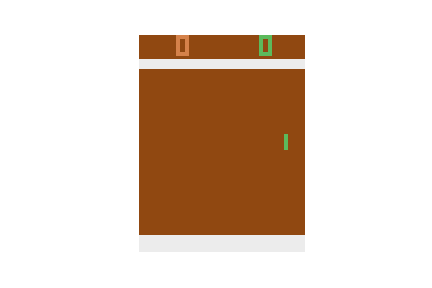
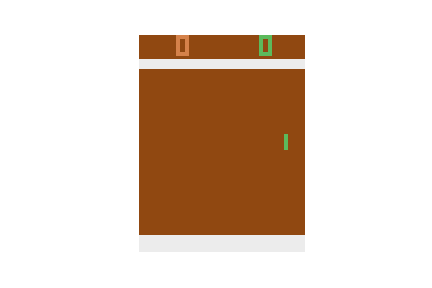
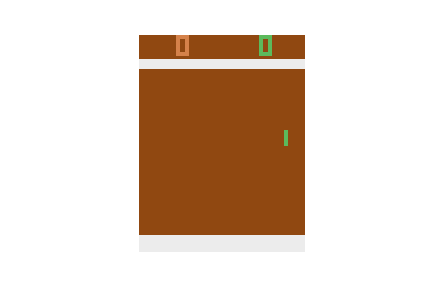
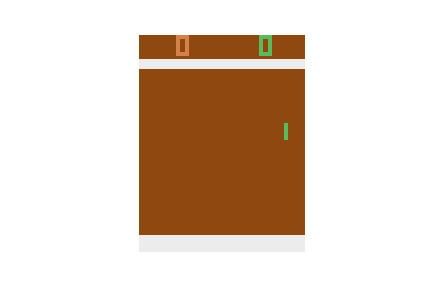
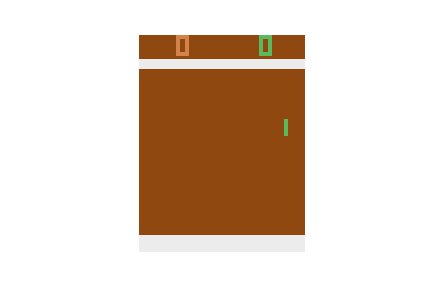
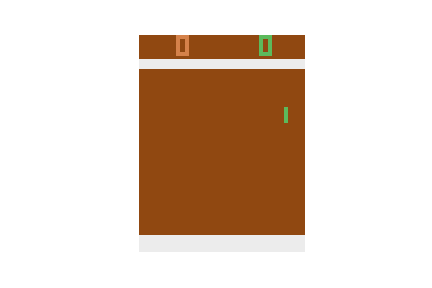
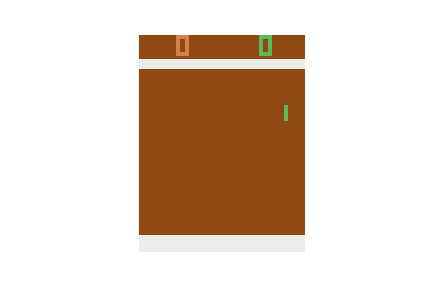
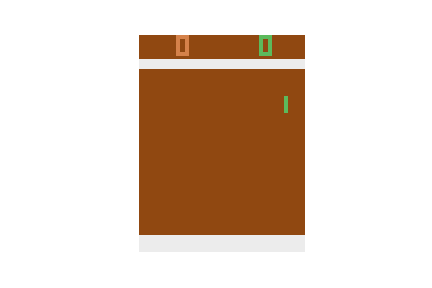
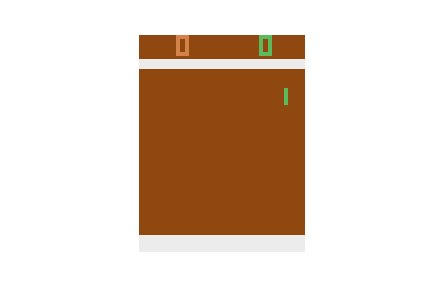
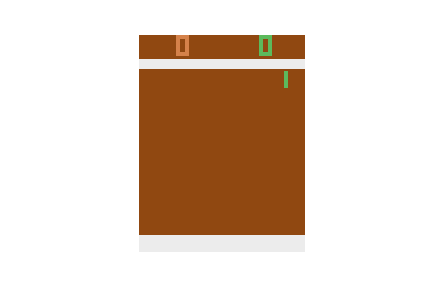
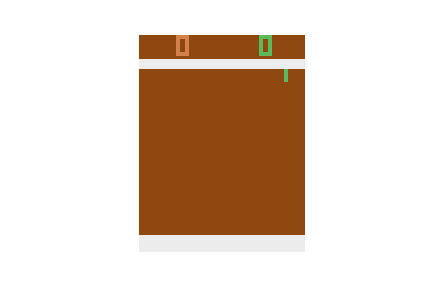
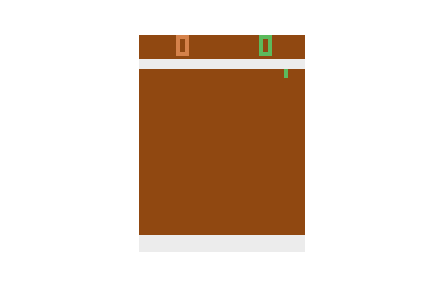
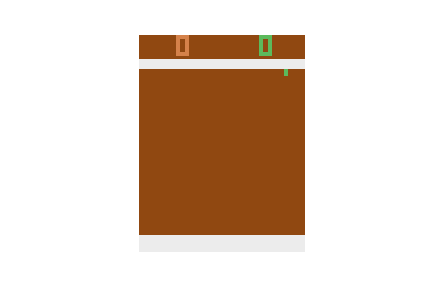
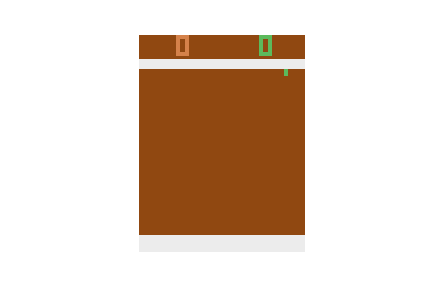
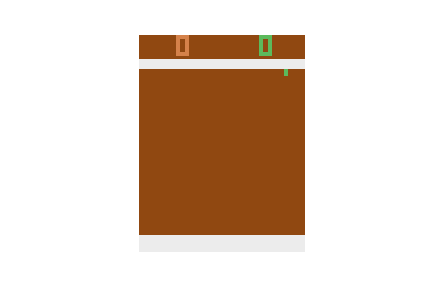
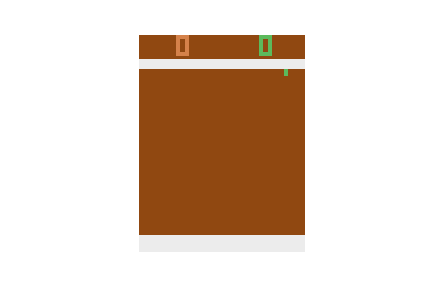
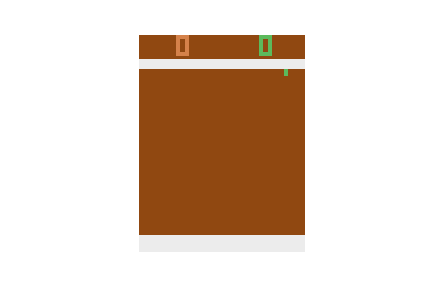
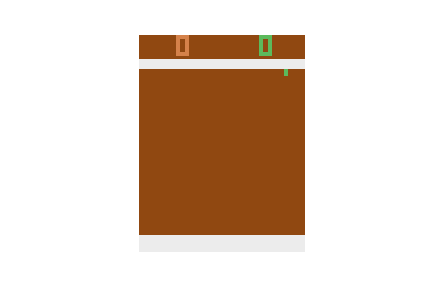
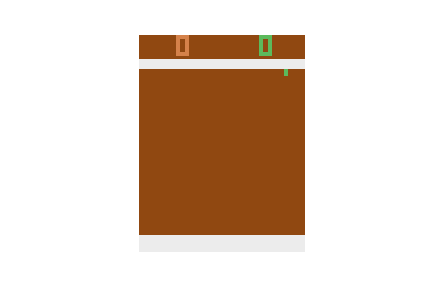
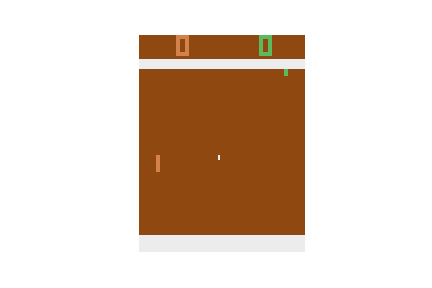
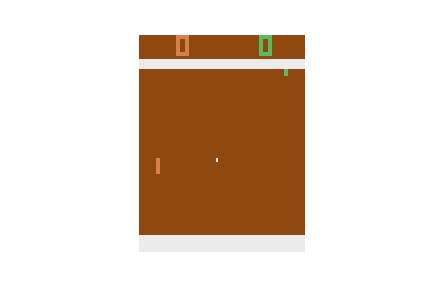
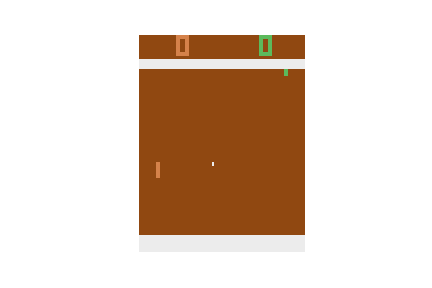
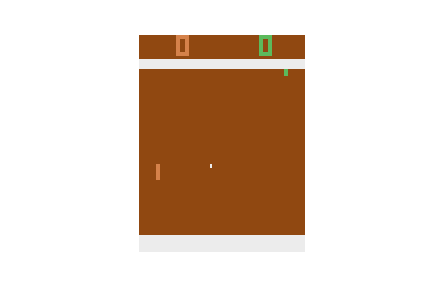
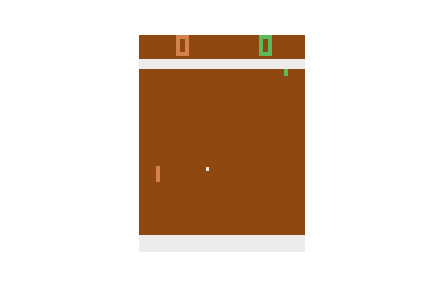
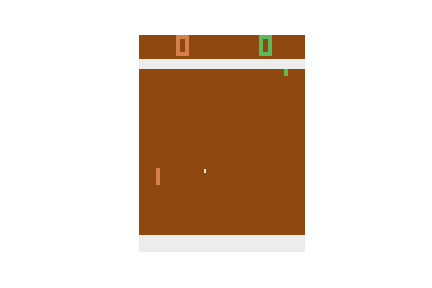
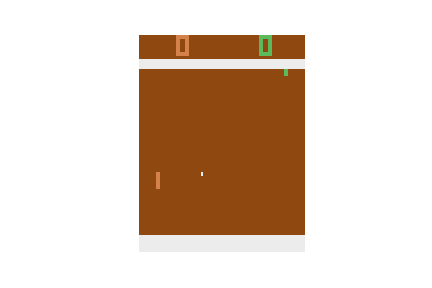
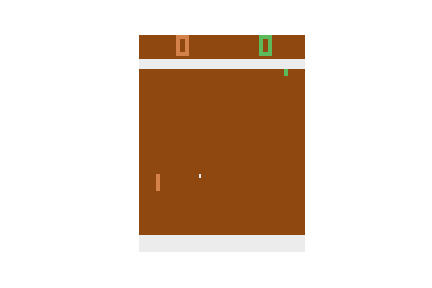
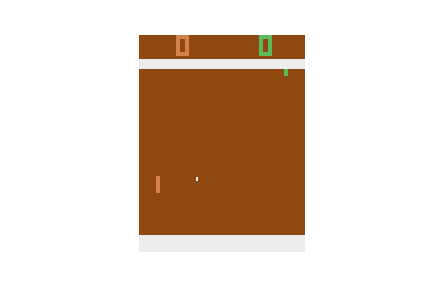
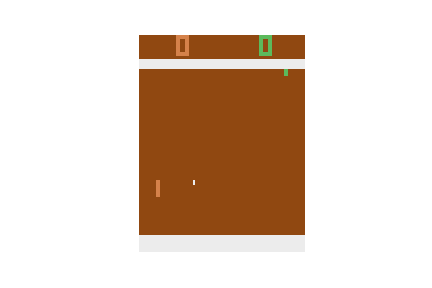
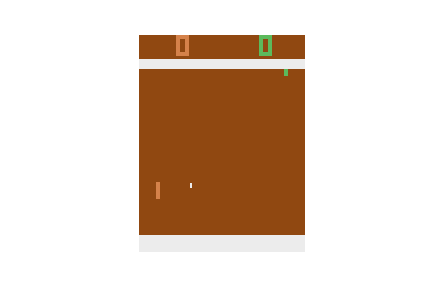
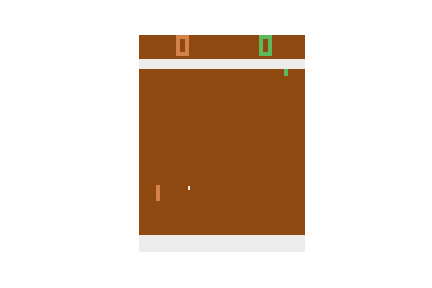
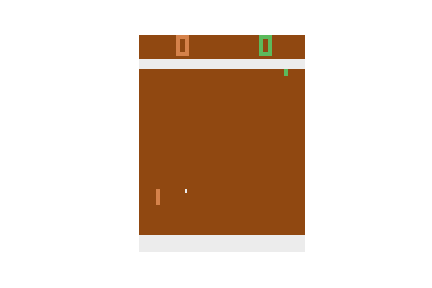
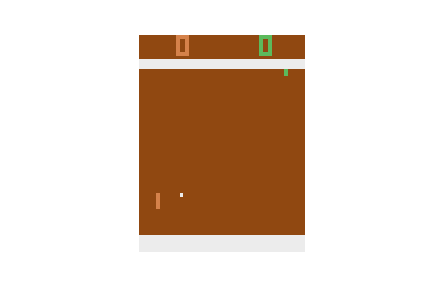
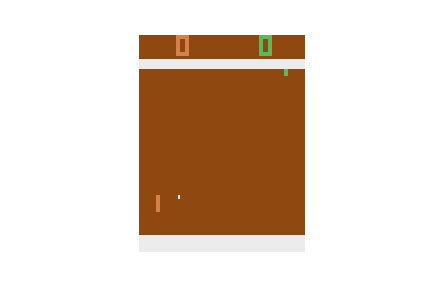
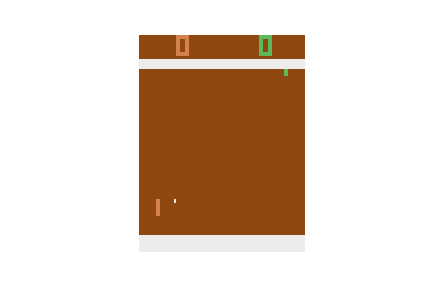
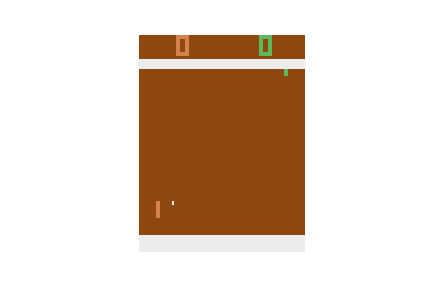
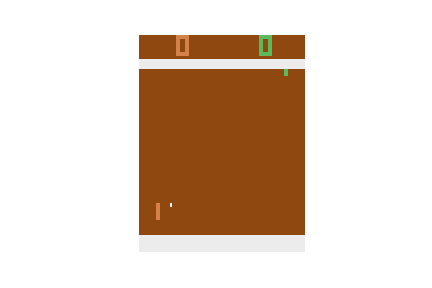
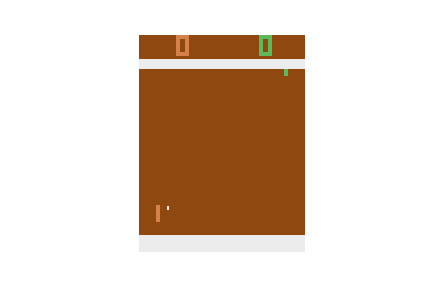
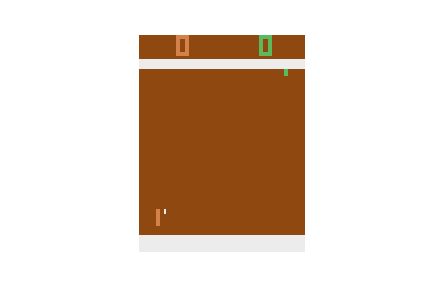
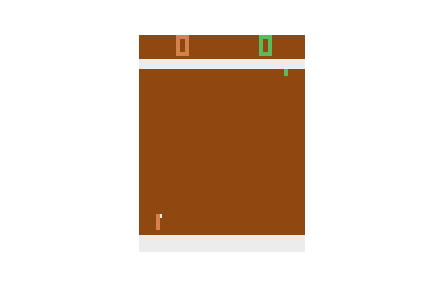
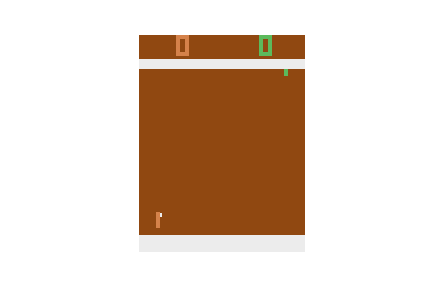
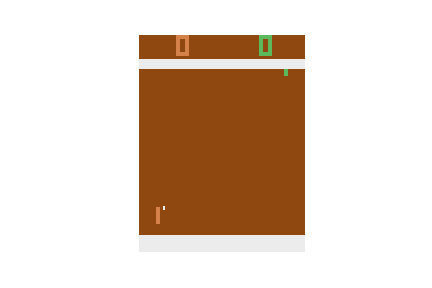
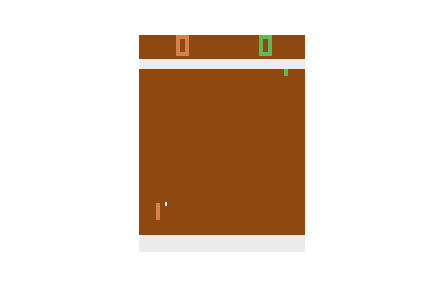
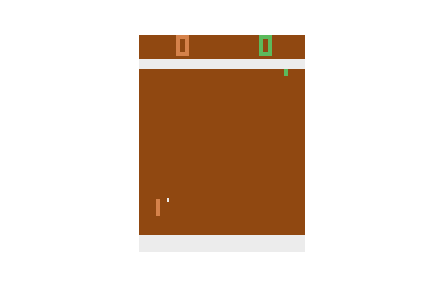
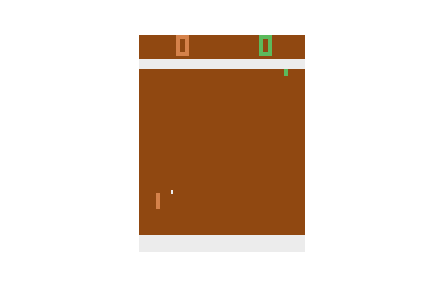
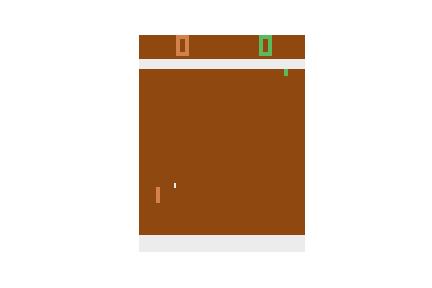
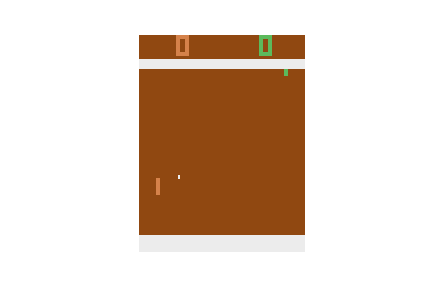
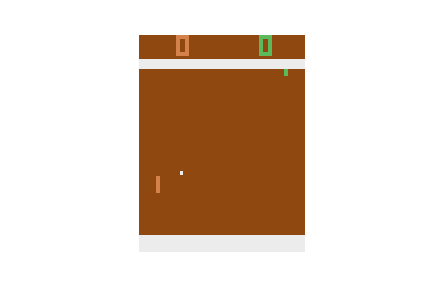
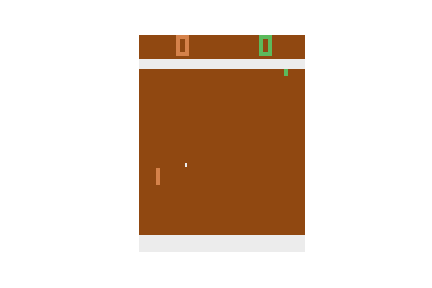
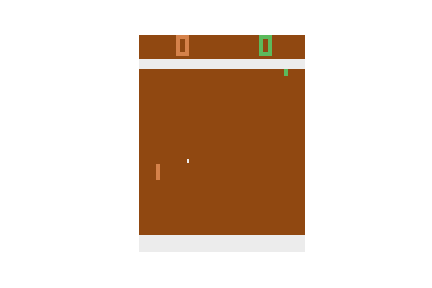
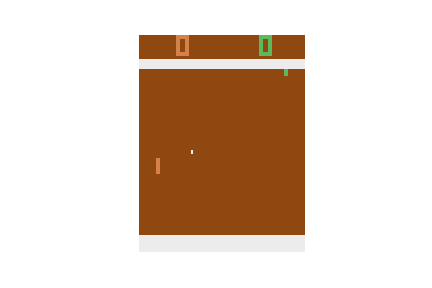
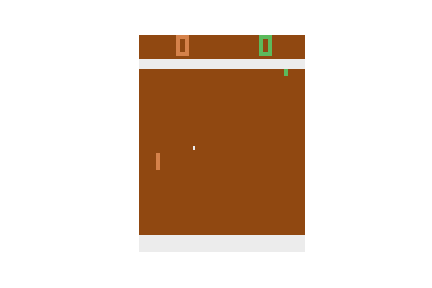
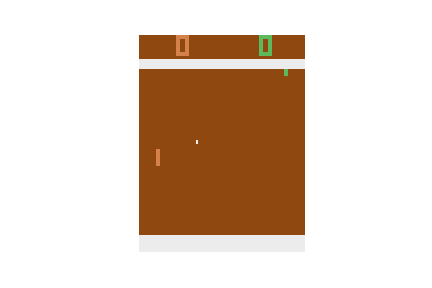
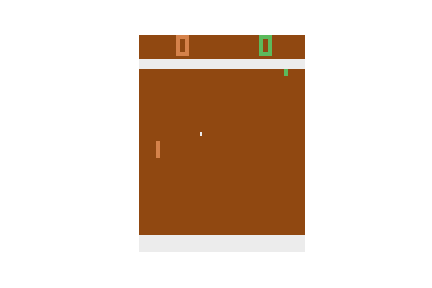
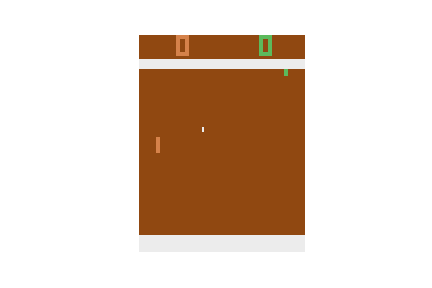
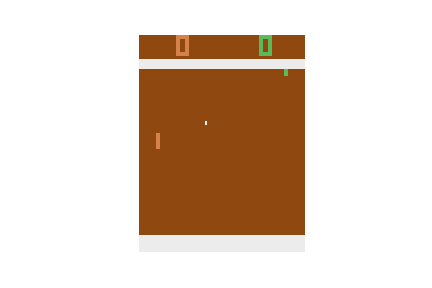
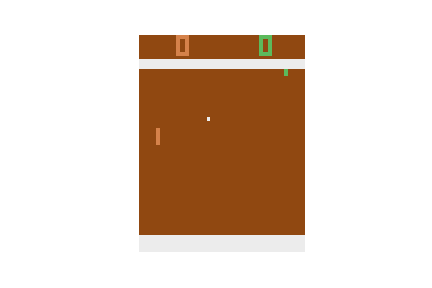
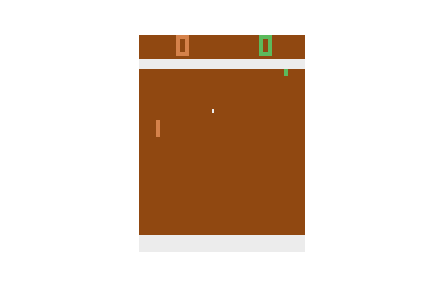
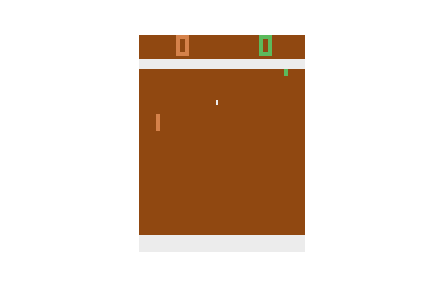
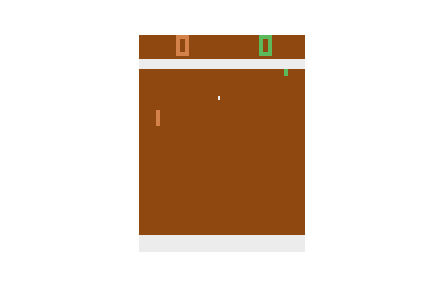
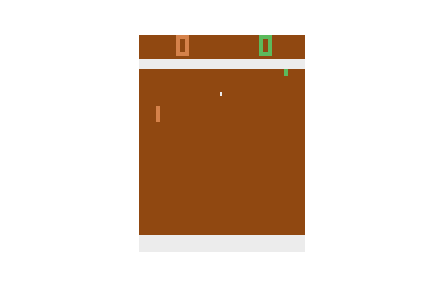
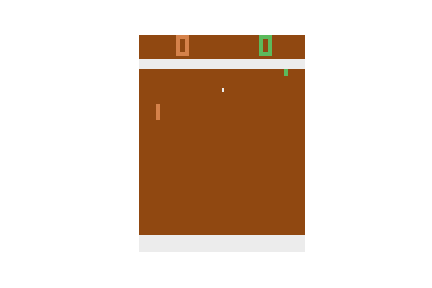
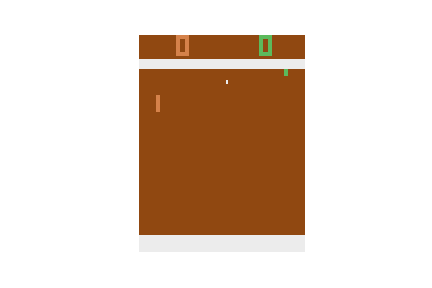
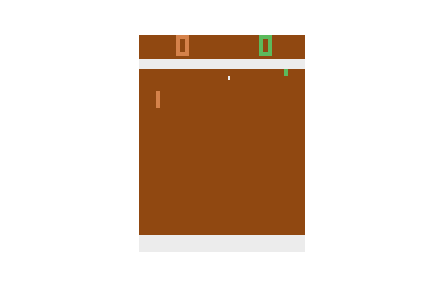
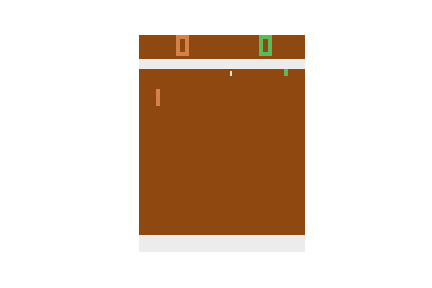
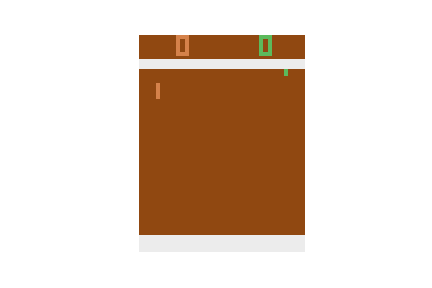
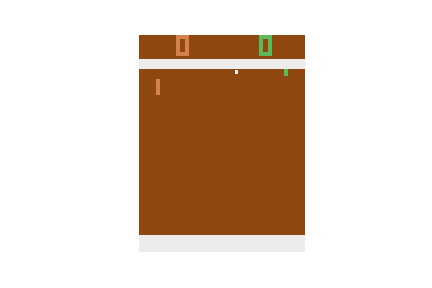
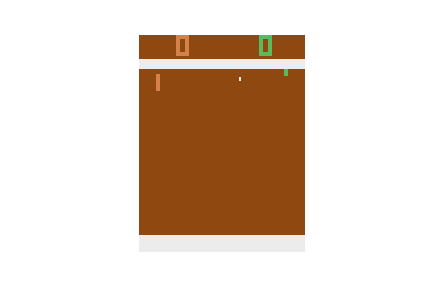
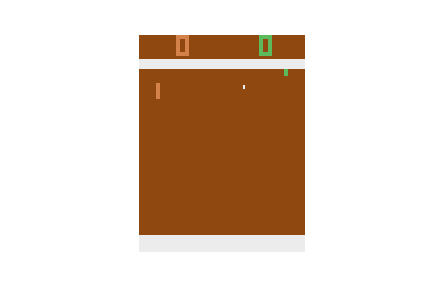
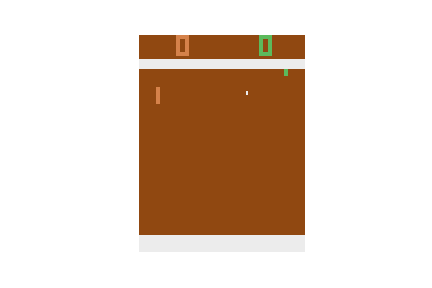
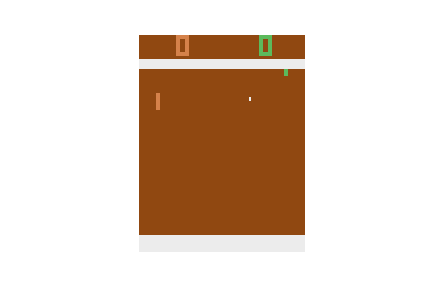
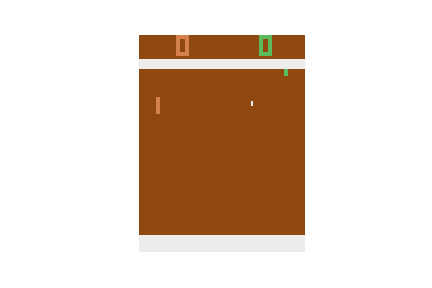
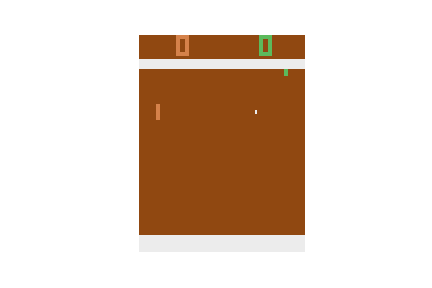
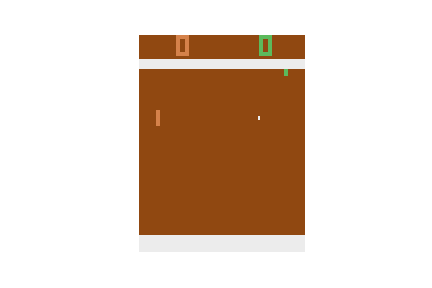
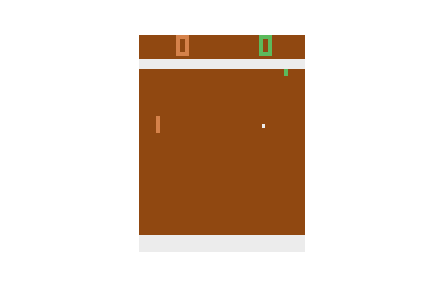
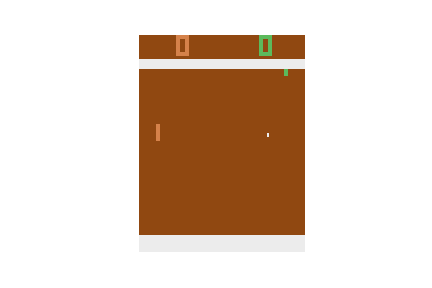
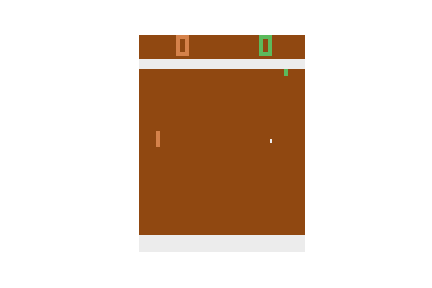
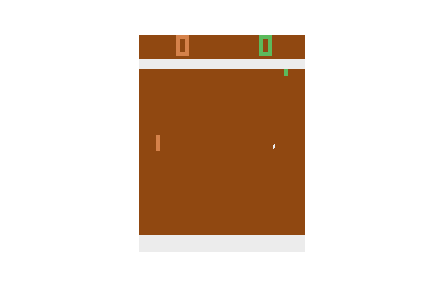
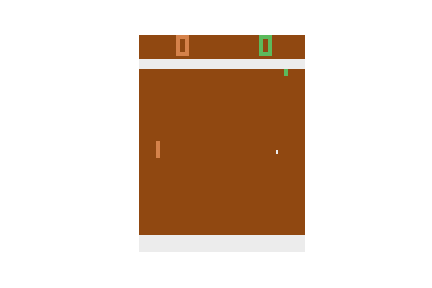
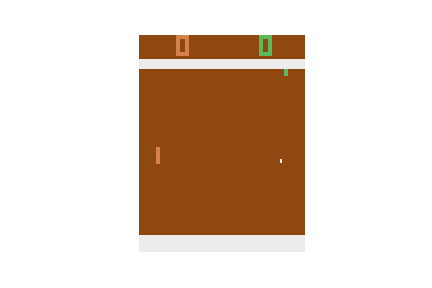
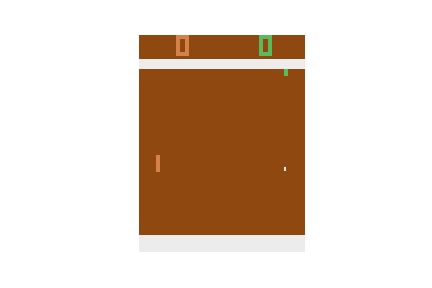
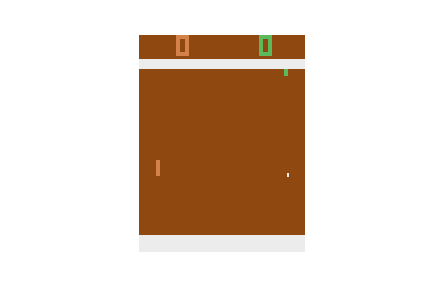
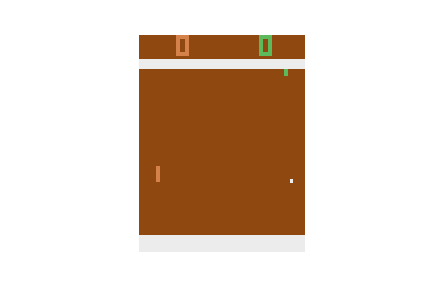
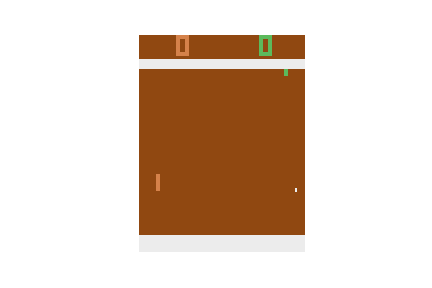
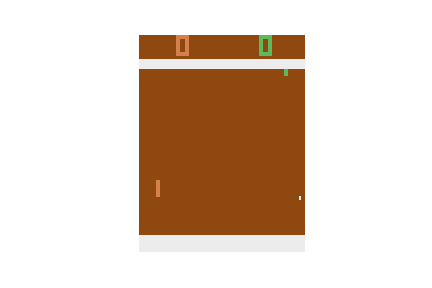
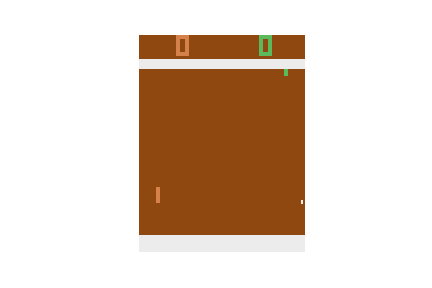
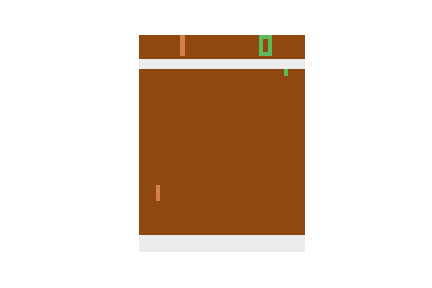
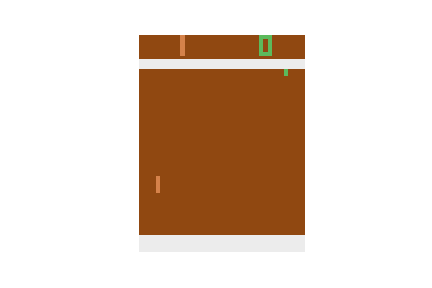
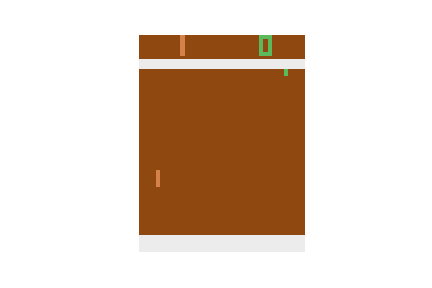
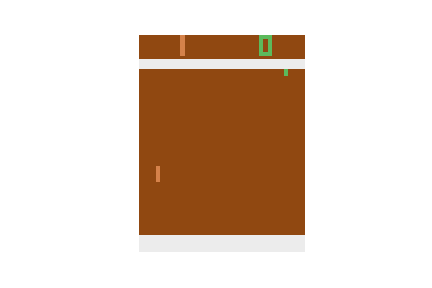
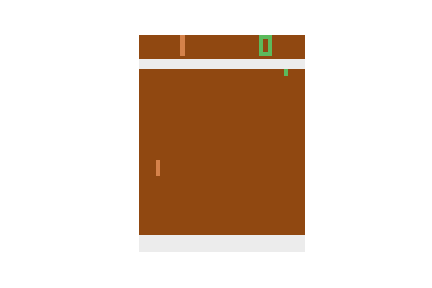
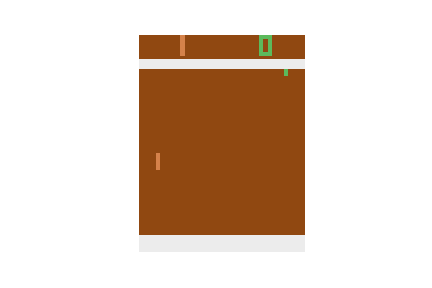
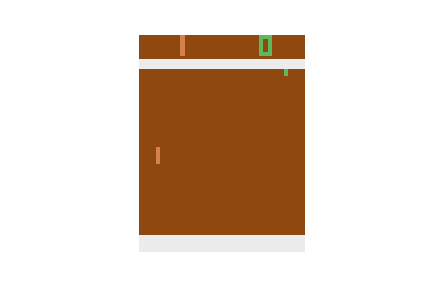
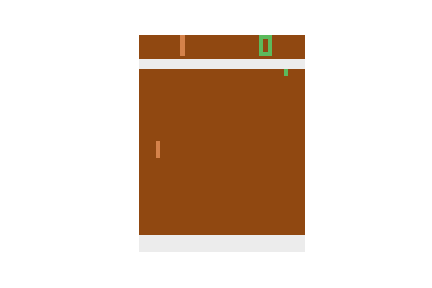
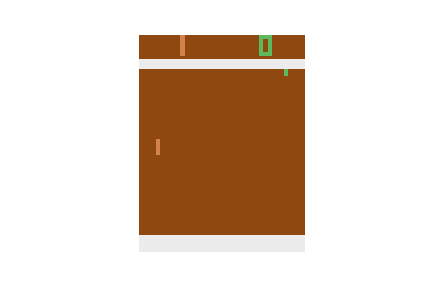
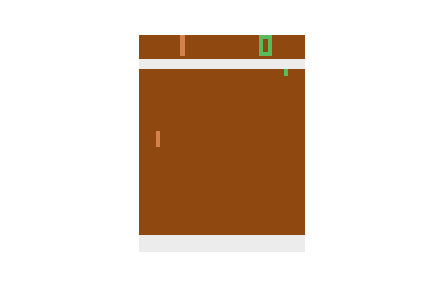
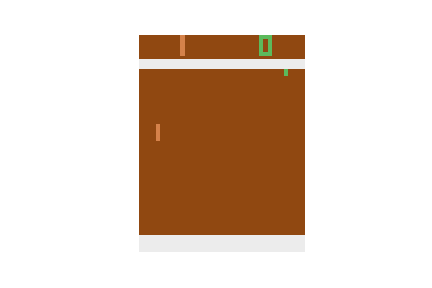
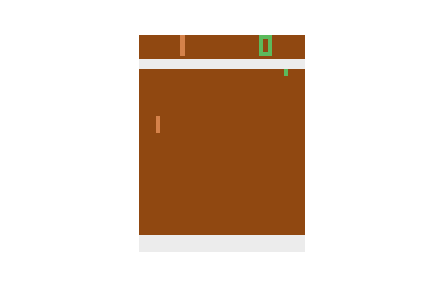
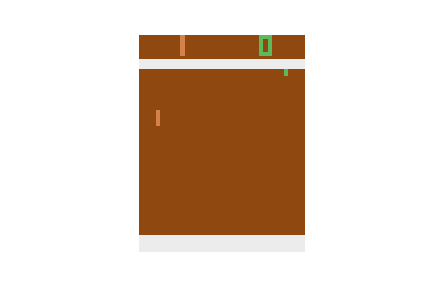
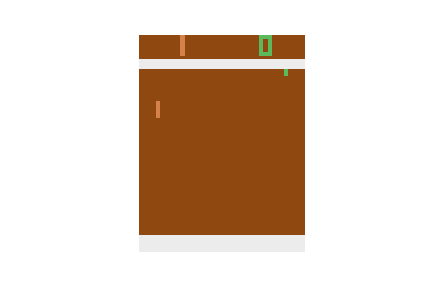
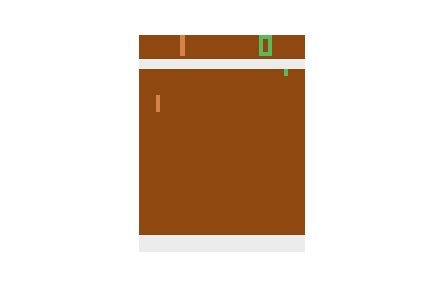
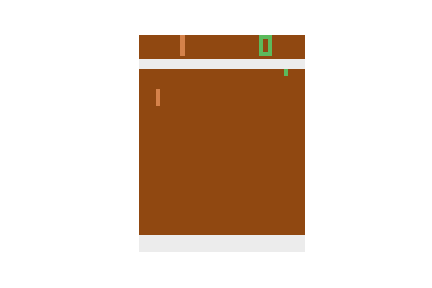
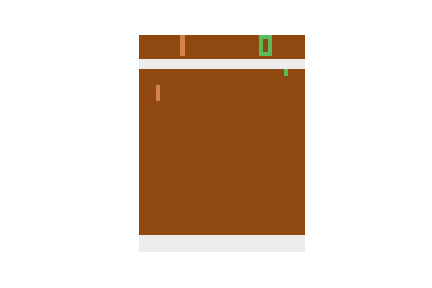
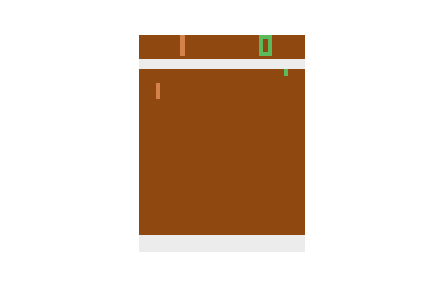
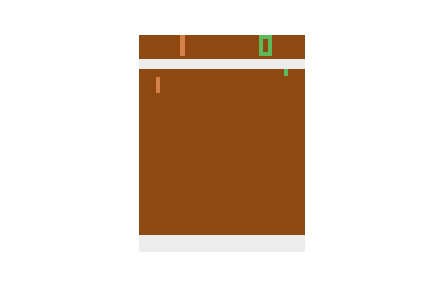
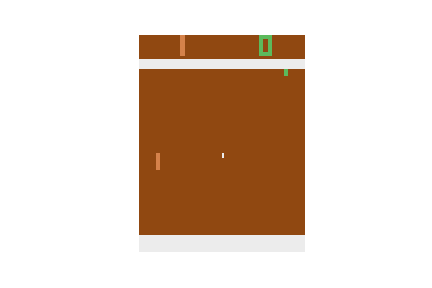
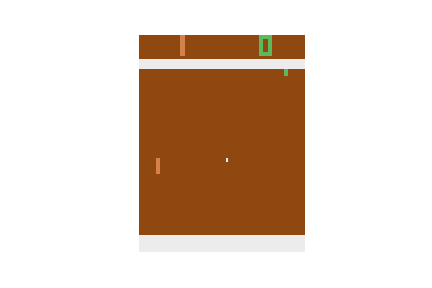
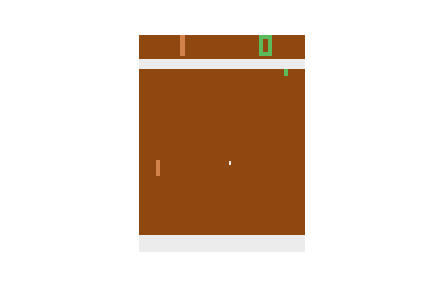
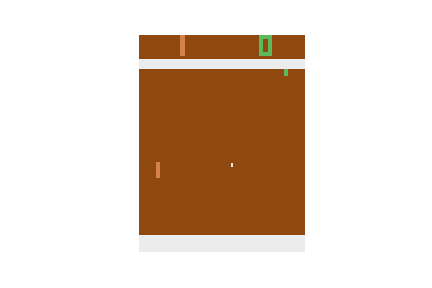
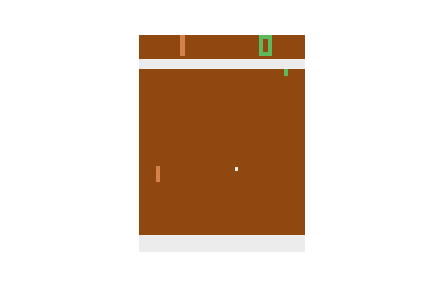
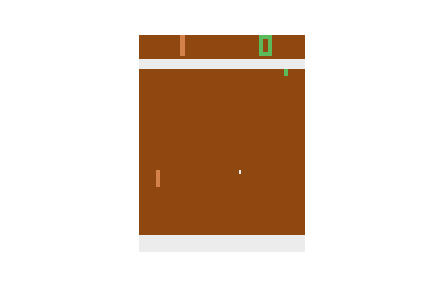
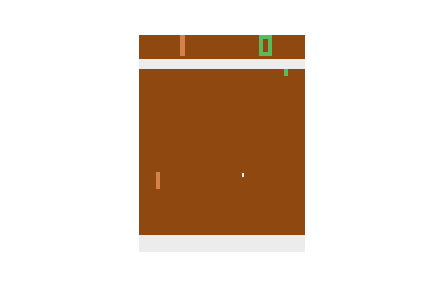
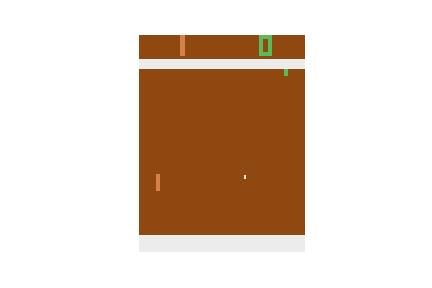
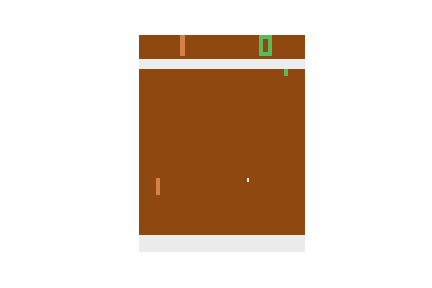
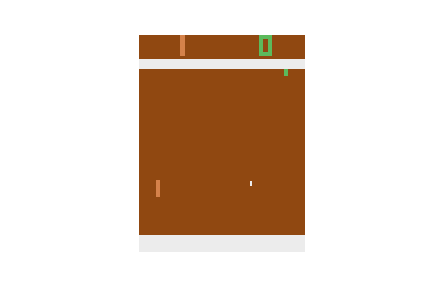
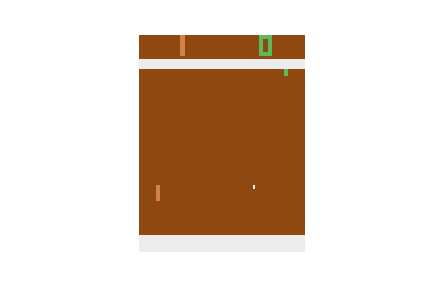
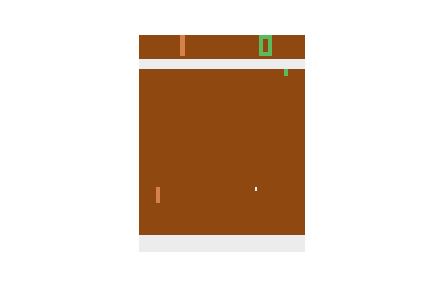
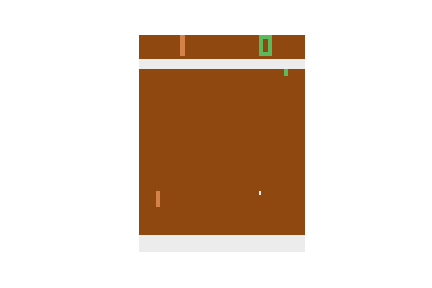
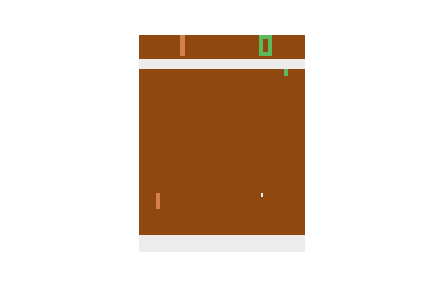
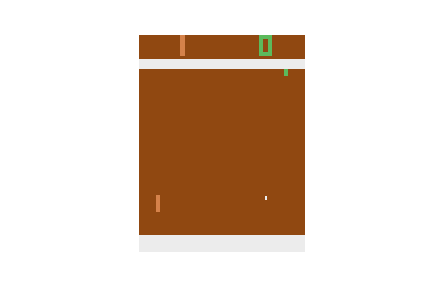
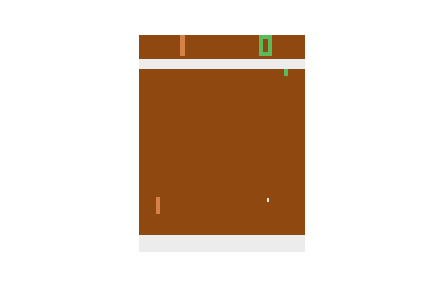
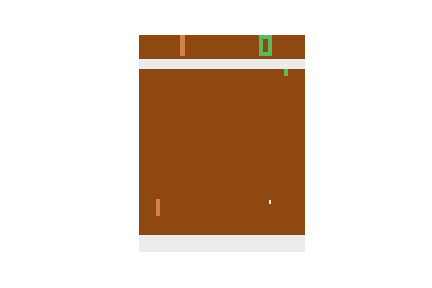
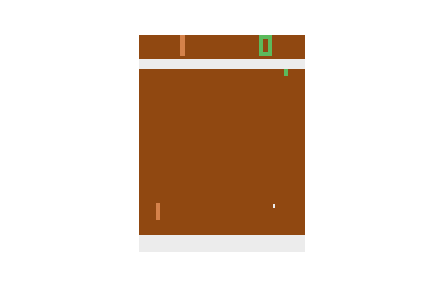
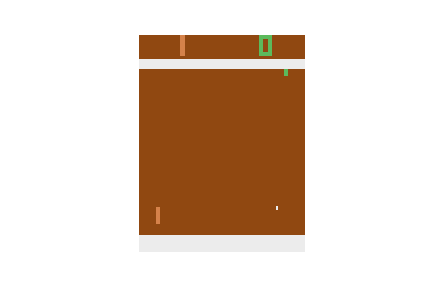
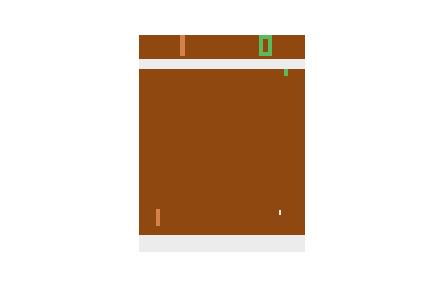
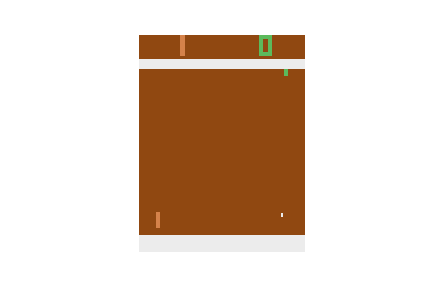
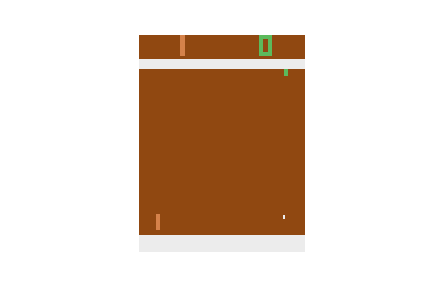
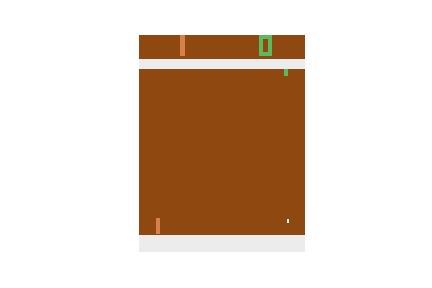
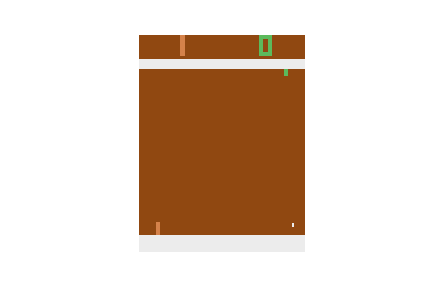
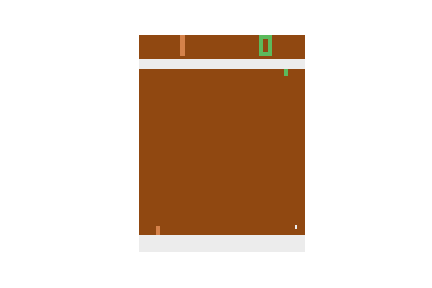
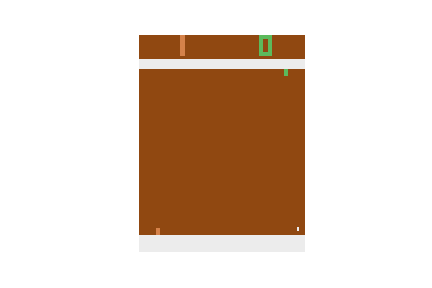
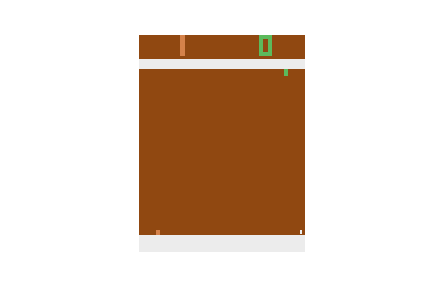
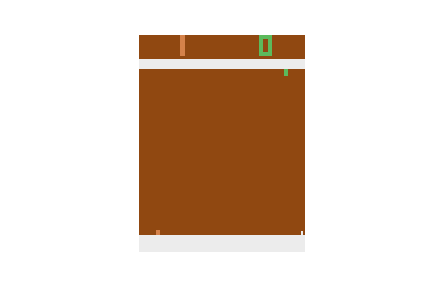
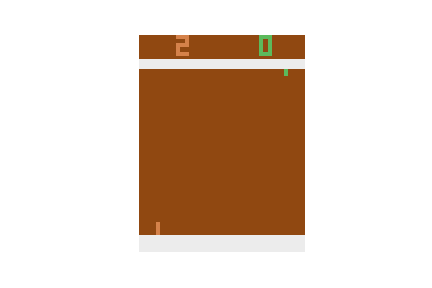
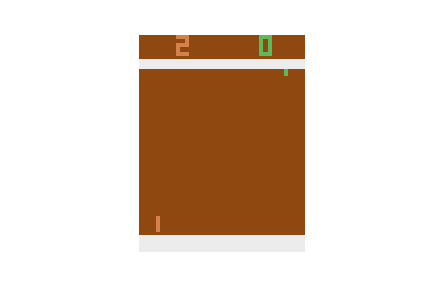
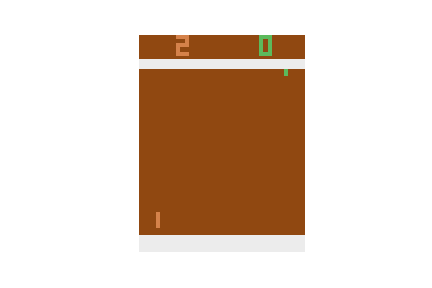
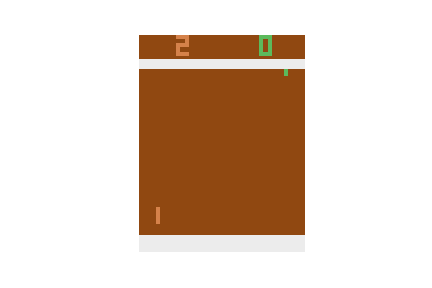
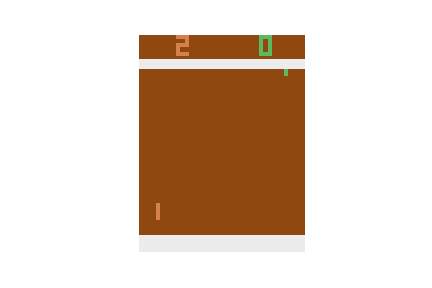
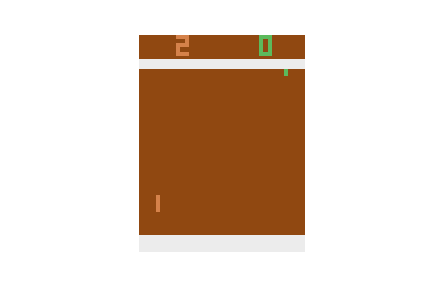
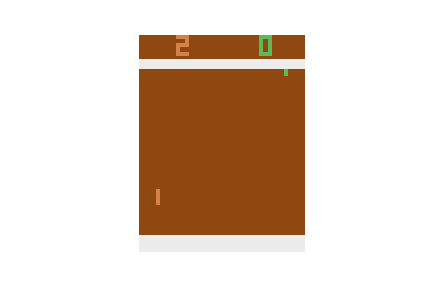
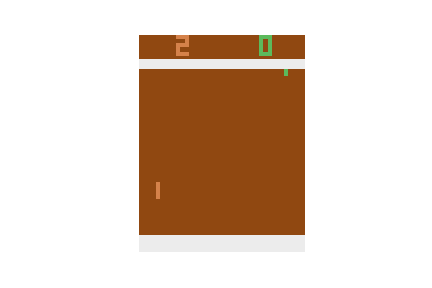
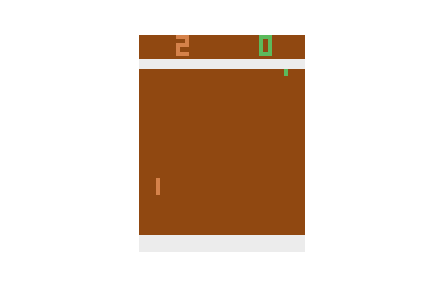
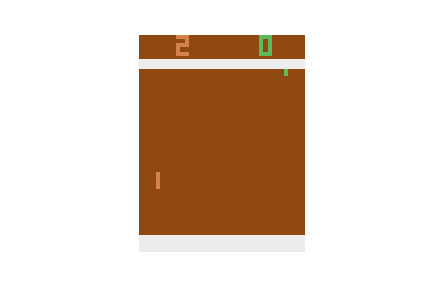
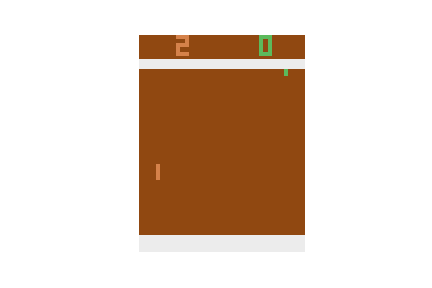
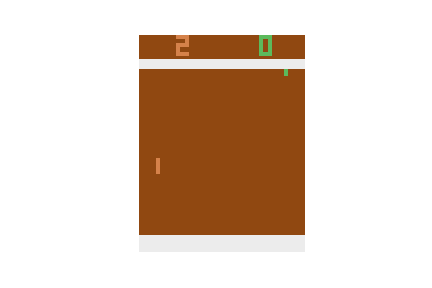
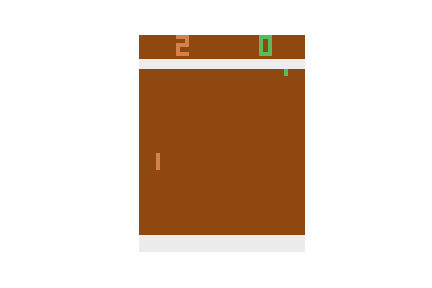
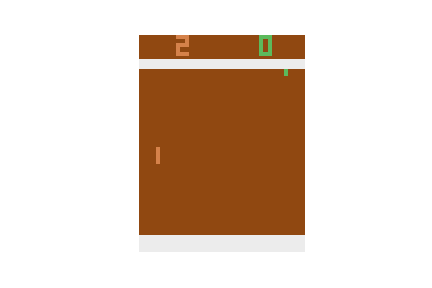
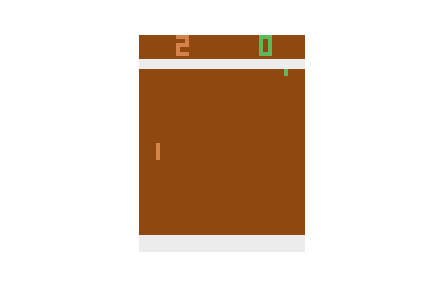
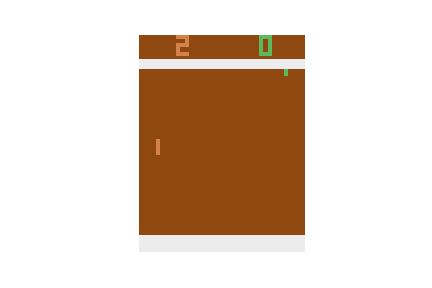
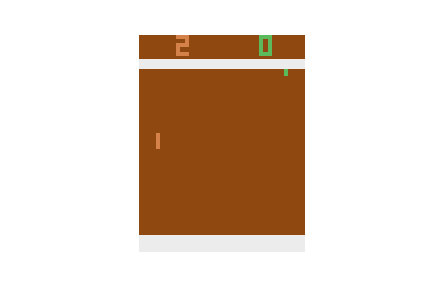
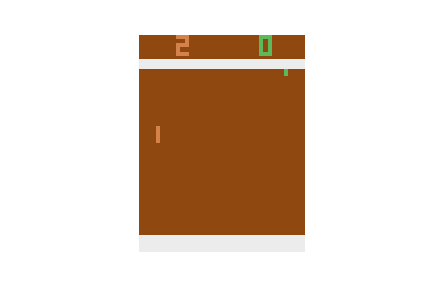
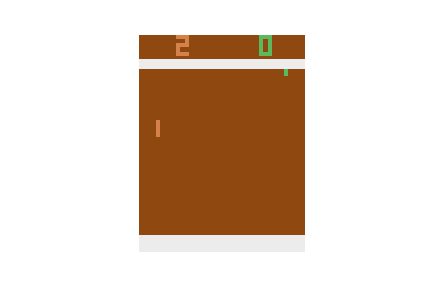
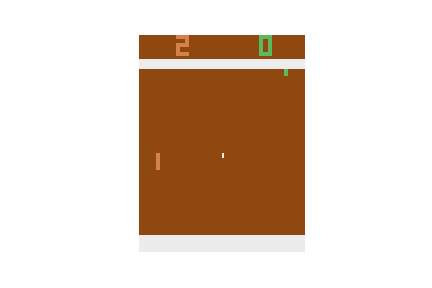
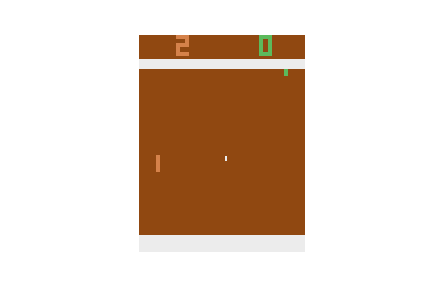
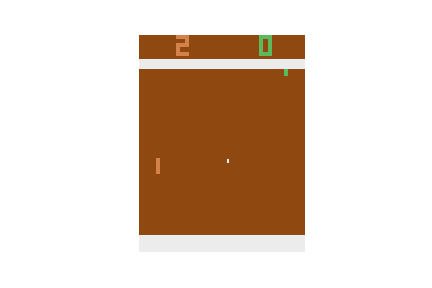
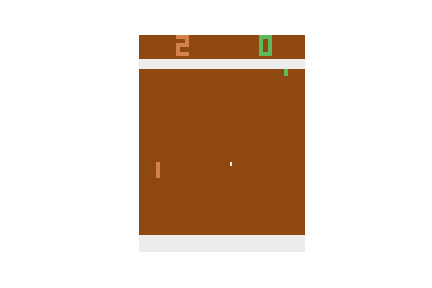
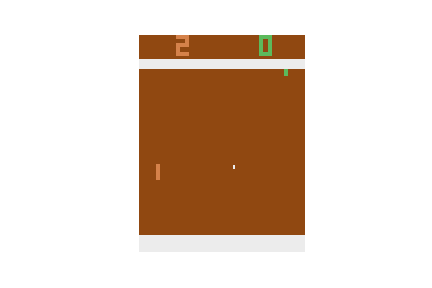
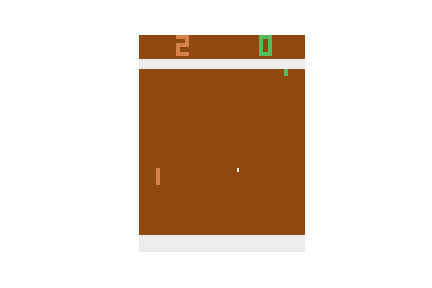
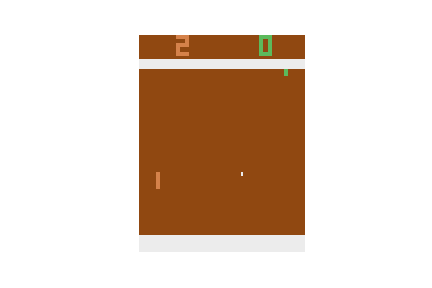
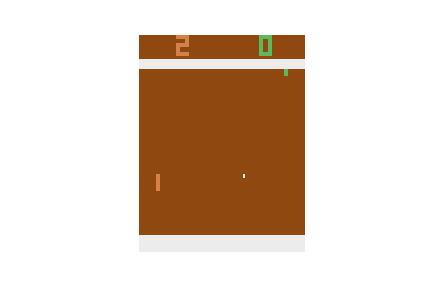
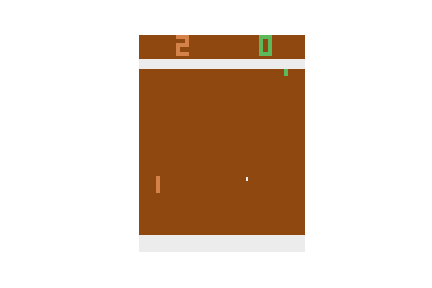
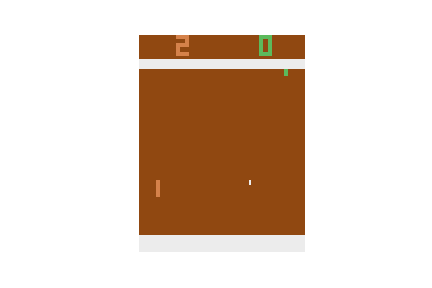
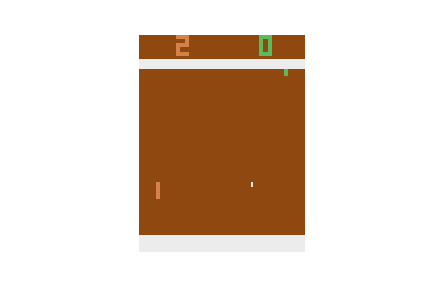
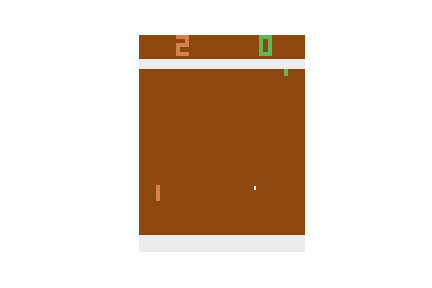
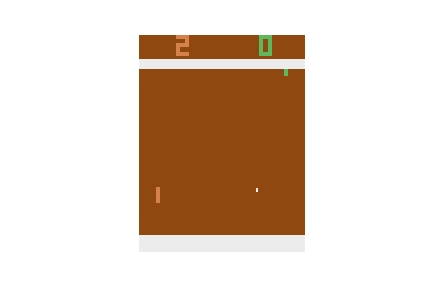
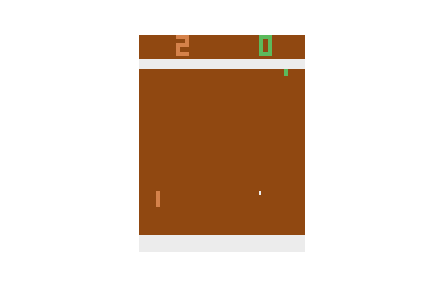
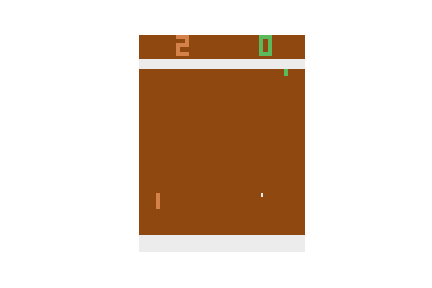
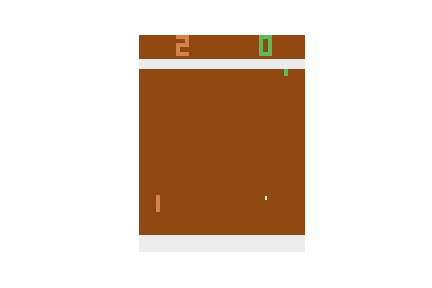
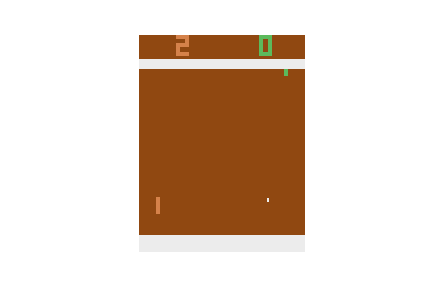
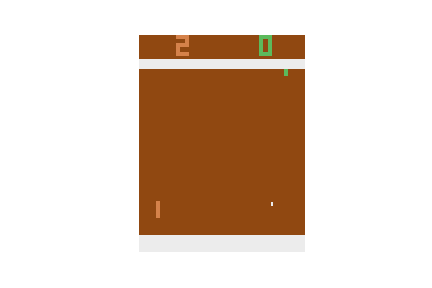
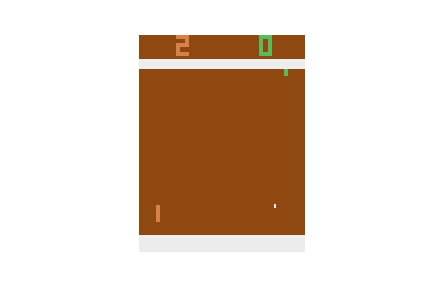
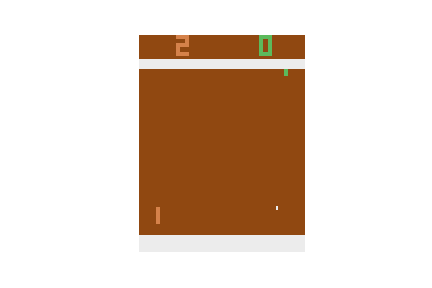
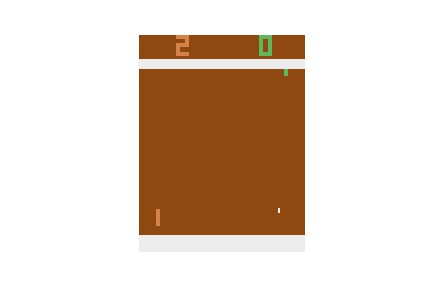
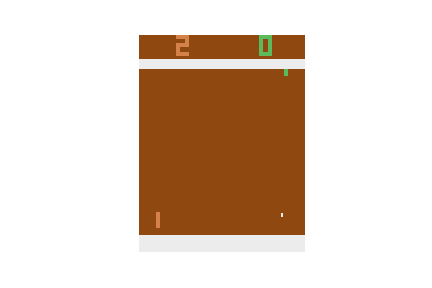
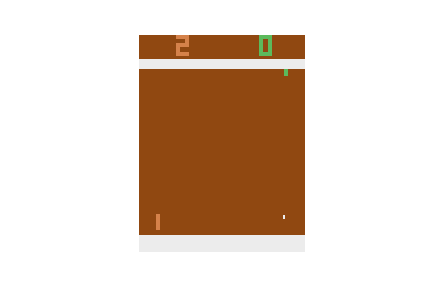
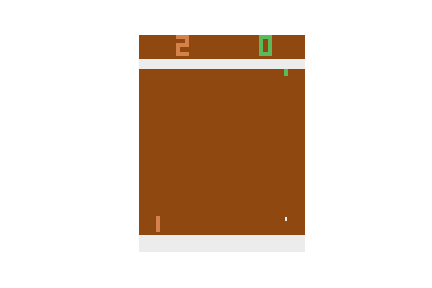
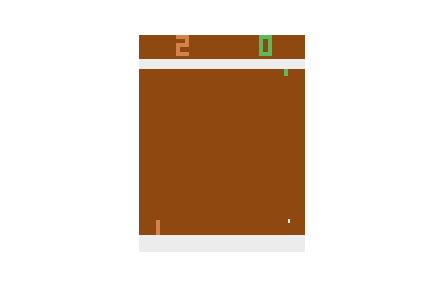
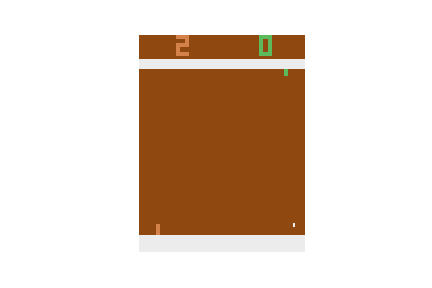
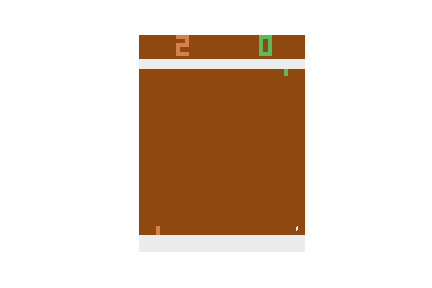
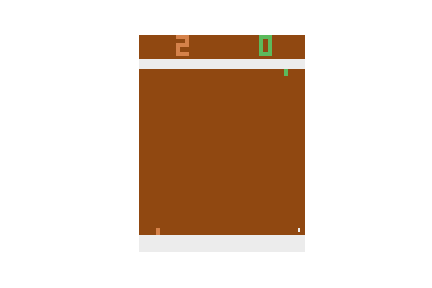
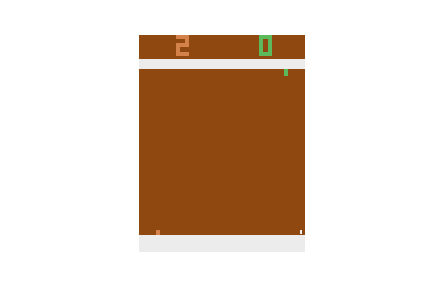
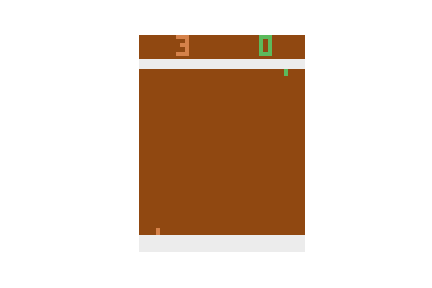
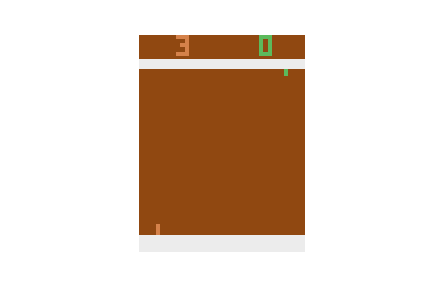
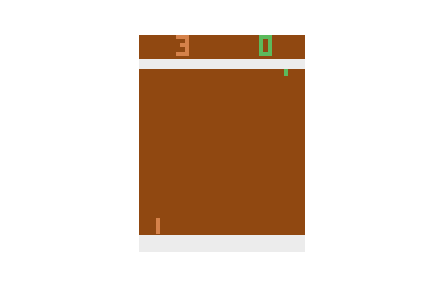
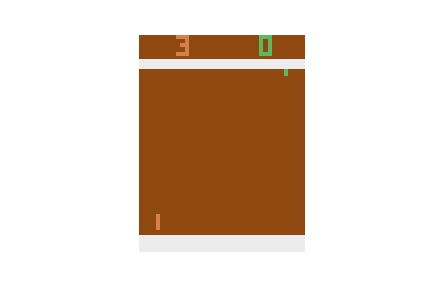
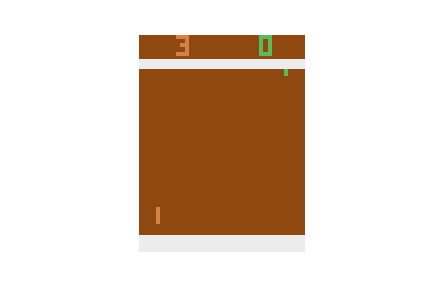
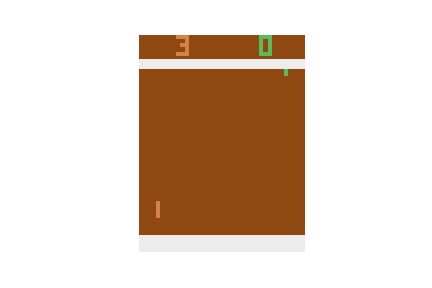
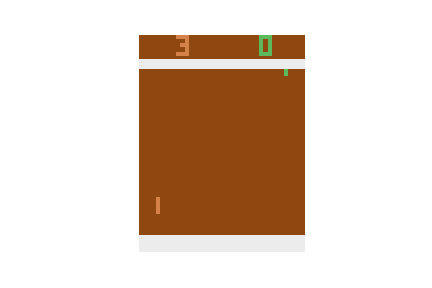
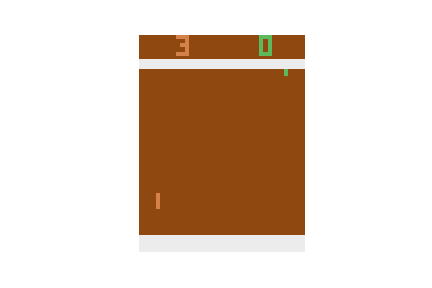
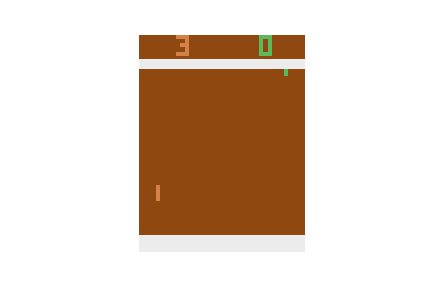
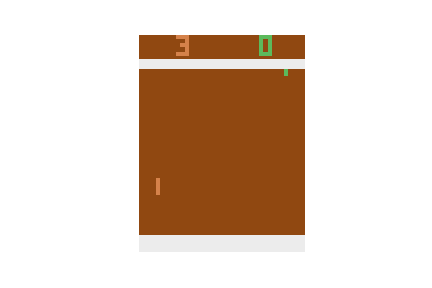
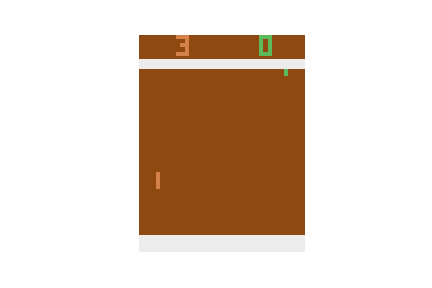
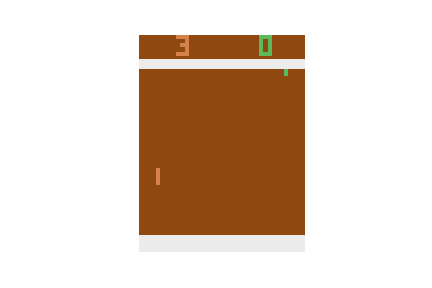
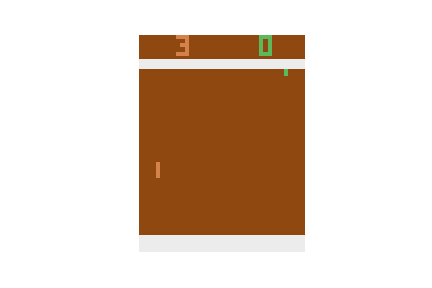
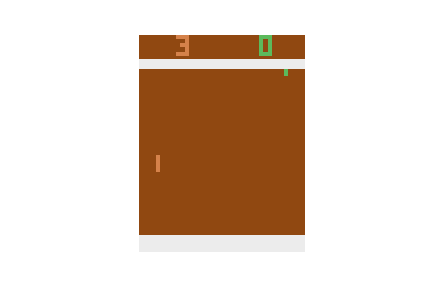
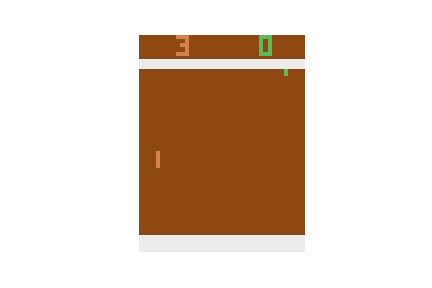
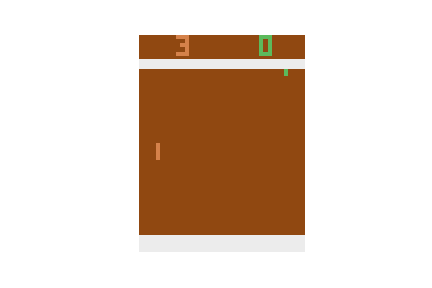
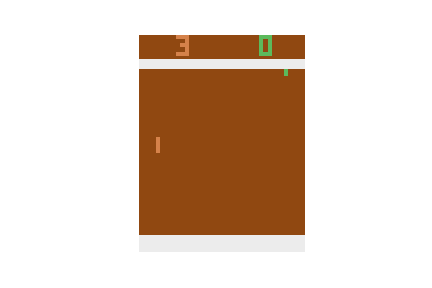
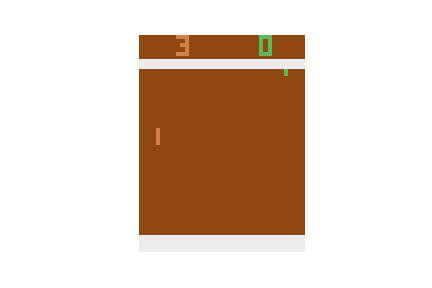
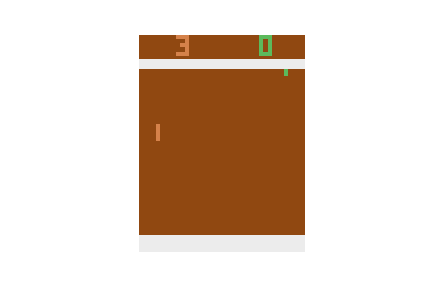

In [15]:
env_name = 'Pong-ram-v0'

with tf.Graph().as_default():
  agent, _, session = run_experiment(env_name=env_name,
               n_iter=1,
               num_ep_per_iter=32,
               gamma=0.99, ####???
               max_episode_len=150,
               learning_rate=5e-3,
               enable_critic=False,
               entropy_weight = 0.012,
               seed=3,
               n_layers=10,
               size=30)

  frames = collect_n_episodes(1, 200, gym.make(env_name), 
                              agent, session, animate=True)
  
  display_frames_as_gif(frames)